In [1]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from stop_words import get_stop_words
from prettytable import PrettyTable
import pickle
import warnings
print("Setup Complete")

Setup Complete


### Read real estate dataset from Kaggle as dataframe and analyze it

In [2]:
data_path = "data/"
real_estate_data = pd.read_csv(data_path+"uae_real_estate_2024.csv")

In [3]:
real_estate_data.head()

,title,displayAddress,bathrooms,bedrooms,addedOn,type,price,verified,priceDuration,sizeMin,furnishing,description
0,Great ROI I High Floor I Creek View,"Binghatti Canal, Business Bay, Dubai",3,2,2024-08-14T12:02:53Z,Residential for Sale,2500000,True,sell,1323 sqft,NO,MNA Properties is delighted to offer this apar...
1,Full Sea View | Beach Life | Brand New Residence,"La Vie, Jumeirah Beach Residence, Dubai",3,2,2024-08-13T05:45:16Z,Residential for Sale,7200000,True,sell,1410 sqft,YES,"Apartment for sale in La Vie, Jumeirah Beach R..."
2,Green Belt | Corner Unit | Spacious Plot,"La Rosa 6, Villanova, Dubai Land, Dubai",3,4,2024-08-14T06:24:28Z,Residential for Sale,3600000,True,sell,2324 sqft,NO,Treo Homes is very pleased to be bringing to t...
3,2BR+Study | Near Pool and Park | Private,"Springs 15, The Springs, Dubai",3,2,2024-08-15T06:07:22Z,Residential for Sale,2999999,True,sell,1647 sqft,NO,2 Bedrooms + Study | Near Pool &amp; Park | Pr...
4,Vacant | Well Maintained | Area Expert,"Noor Townhouses, Town Square, Dubai",3,3,2024-08-09T08:28:59Z,Residential for Sale,2449999,True,sell,2105 sqft,NO,-Type 1\n-3 Bed+Maid\n-Close To Amenities\n-BU...


In [4]:
real_estate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5058 entries, 0 to 5057
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           5058 non-null   object
 1   displayAddress  5058 non-null   object
 2   bathrooms       4938 non-null   object
 3   bedrooms        4935 non-null   object
 4   addedOn         5058 non-null   object
 5   type            5058 non-null   object
 6   price           5058 non-null   int64 
 7   verified        5058 non-null   bool  
 8   priceDuration   5058 non-null   object
 9   sizeMin         5058 non-null   object
 10  furnishing      5056 non-null   object
 11  description     5057 non-null   object
dtypes: bool(1), int64(1), object(10)
memory usage: 439.7+ KB


In [5]:
# there are almost no missing values
missing_values = real_estate_data.isna().sum().div(real_estate_data.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)
missing_values.columns  = ['% missing_values']
missing_values

,% missing_values
bedrooms,2.431791
bathrooms,2.372479
furnishing,0.039541
description,0.019771
title,0.000000
displayAddress,0.000000
addedOn,0.000000
type,0.000000
price,0.000000
verified,0.000000


### Prepare and visualize columns

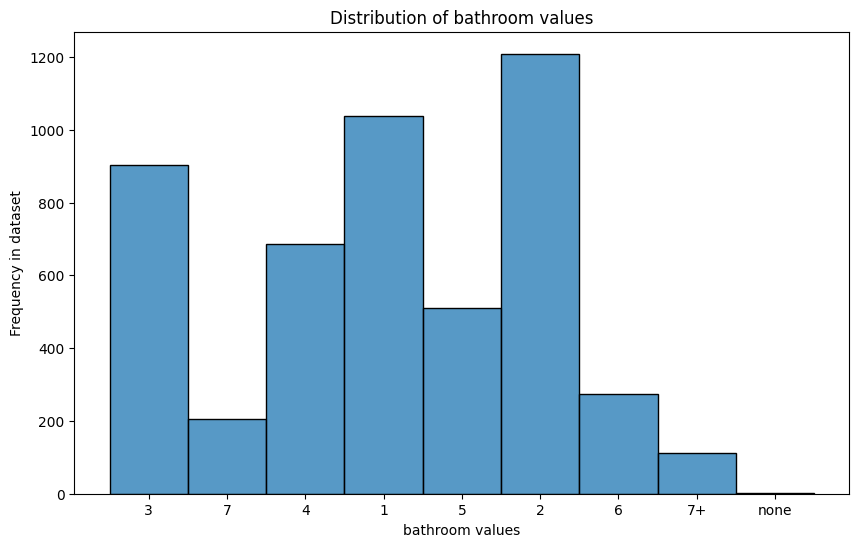

In [6]:
# not numerical due to 7+
plt.figure(figsize=(10, 6))
sns.histplot(data=real_estate_data, x='bathrooms')
plt.title('Distribution of bathroom values')
plt.xlabel('bathroom values')
plt.ylabel('Frequency in dataset')
plt.show()

In [7]:
real_estate_data['bathrooms'] = real_estate_data['bathrooms'].str.replace('7+', '8')
real_estate_data['bathrooms'] = real_estate_data['bathrooms'].str.replace('none', '0')
real_estate_data['bathrooms'] = pd.to_numeric(real_estate_data['bathrooms'])
real_estate_data['bathrooms'] = real_estate_data['bathrooms'].fillna(0)
real_estate_data['bathrooms'] = real_estate_data['bathrooms'].astype(np.int64)

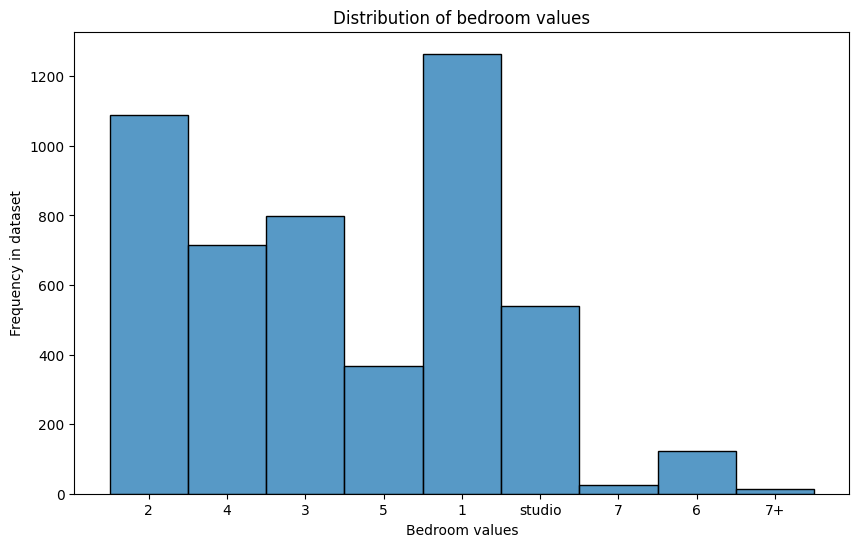

In [8]:
# not numerical due to 7+ and studio
plt.figure(figsize=(10, 6))
sns.histplot(data=real_estate_data, x='bedrooms')
plt.title('Distribution of bedroom values')
plt.xlabel('Bedroom values')
plt.ylabel('Frequency in dataset')
plt.show()

In [9]:
real_estate_data['bedrooms'] = real_estate_data['bedrooms'].str.replace('7+', '8')
real_estate_data['bedrooms'] = real_estate_data['bedrooms'].str.replace('studio', '9')
real_estate_data['bedrooms'] = pd.to_numeric(real_estate_data['bedrooms'])
real_estate_data['bedrooms'] = real_estate_data['bedrooms'].fillna(0)
real_estate_data['bedrooms'] = real_estate_data['bedrooms'].astype(np.int64)

In [10]:
# only one type
real_estate_data["type"].unique()

array(['Residential for Sale'], dtype=object)

<Axes: xlabel='verified', ylabel='Count'>

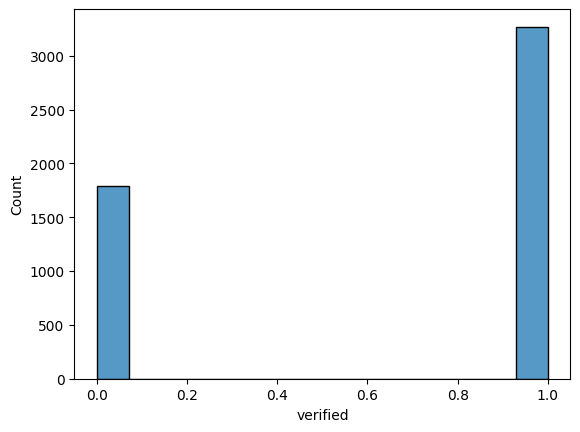

In [11]:
# boolean type
sns.histplot(data=real_estate_data, x="verified")

In [13]:
# only one value
real_estate_data["priceDuration"].unique()

array(['sell'], dtype=object)

<Axes: xlabel='furnishing', ylabel='Count'>

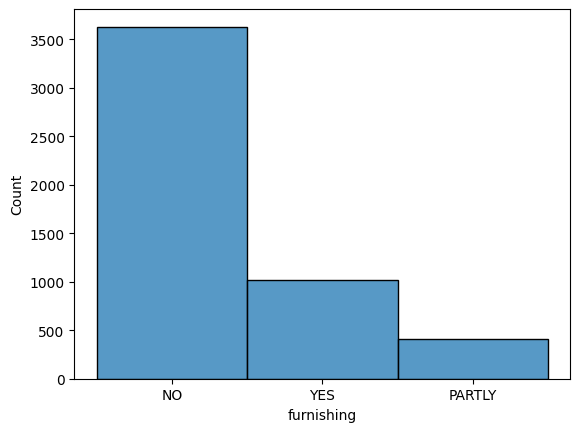

In [14]:
sns.histplot(data=real_estate_data, x="furnishing")

In [15]:
real_estate_data['sizeMin'] = real_estate_data['sizeMin'].str.replace(' sqft', '', regex=True)
real_estate_data['sizeMin'] = pd.to_numeric(real_estate_data['sizeMin'])

<Axes: xlabel='sizeMin', ylabel='Count'>

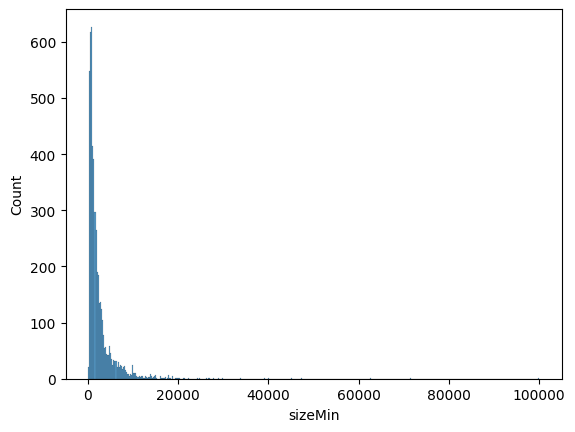

In [16]:
sns.histplot(real_estate_data['sizeMin'])

In [17]:
real_estate_data["price"].describe().apply(lambda x: format(x, 'f'))

count         5058.000000
mean       5050923.614868
std       10009278.198509
min         100000.000000
25%        1200000.000000
50%        2350000.000000
75%        4499375.000000
max      199000000.000000
Name: price, dtype: object

<Axes: xlabel='price', ylabel='Count'>

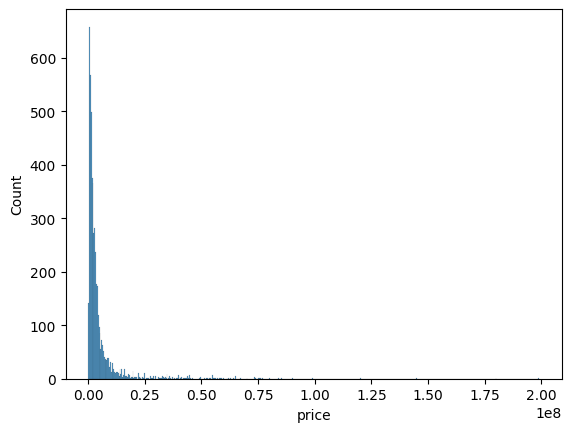

In [18]:
sns.histplot(real_estate_data['price'])

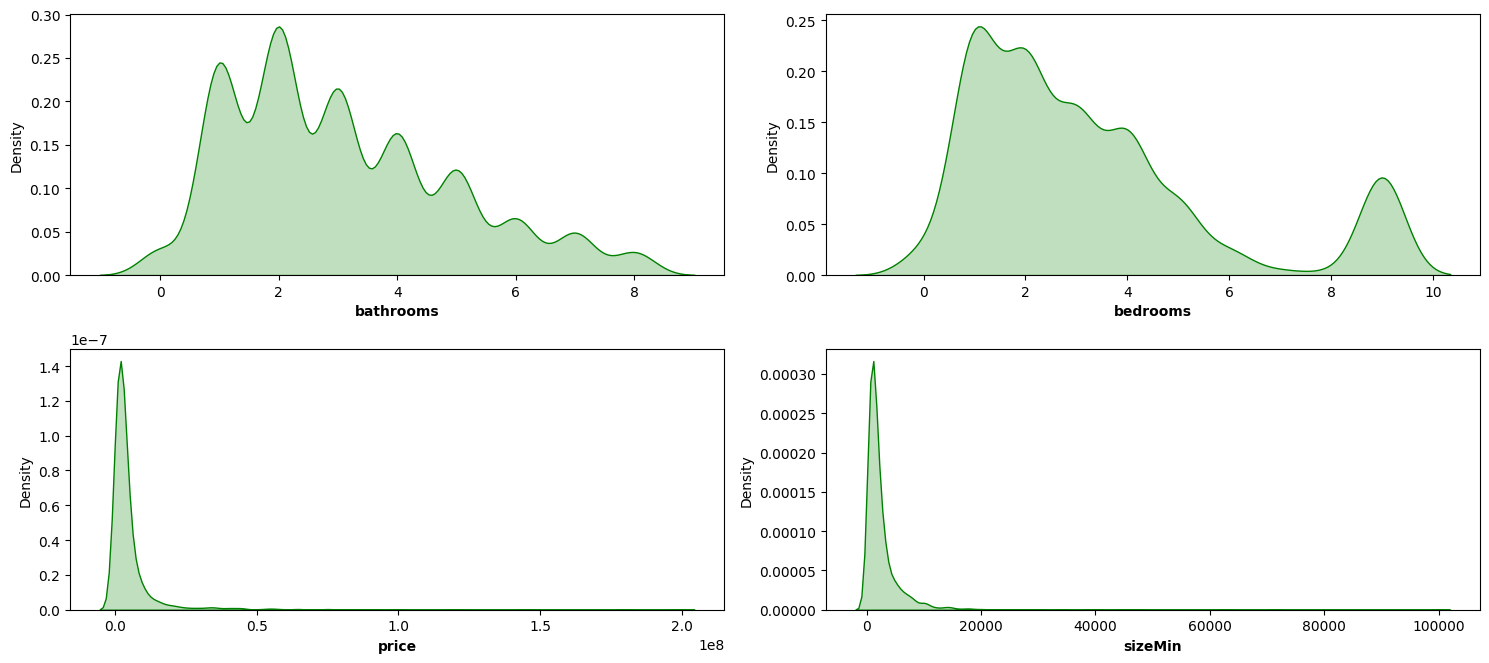

In [19]:
# see https://www.kaggle.com/code/vaasubisht/eda-statisticaltests-gradient-boosting-shap
num_columns = list(real_estate_data[real_estate_data.columns].select_dtypes(include=['int64']).columns)
cat_columns = list(real_estate_data[real_estate_data.columns].select_dtypes(include=['object']).columns)
# kernel density estimate subplots show that the numerical columns have inbalanced data
warnings.filterwarnings("ignore")
plt.figure(figsize=(15, 100))
for i, col in enumerate(num_columns):
    plt.subplot(30, 2, i+1)
    sns.kdeplot(real_estate_data[col], color='green', shade=True)
    plt.xlabel(col, weight='bold')
    plt.tight_layout()